In [1]:
%matplotlib inline
import cv2
import numpy as np
from skimage import io
from skimage import feature
from skimage import color
from matplotlib import pyplot as plt
from collections import defaultdict
#import matplotlib.cbook 
import os
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import linear_model

##Визуальные слова

In [41]:
#construct a patch - subregion of the source image with the size of neibourhood of key point
def get_patch(image, key_point):
    radius = key_point.size
    x, y = key_point.pt    
    x1 = x - radius
    x2 = x + radius
    y1 = y - radius
    y2 = y + radius
    return image[y1:y2, x1:x2]

#calclulate descriptors of the images generated by image_generator
def get_descriptors(image_generator, features_number):
    descriptors = []
    patches = []
    sift = cv2.SIFT(nfeatures=features_number)
    for image in image_generator():
        keys, desc = sift.detectAndCompute(image, None)
        for d, k in zip(desc, keys):
            descriptors.append(d)
            patches.append(get_patch(image, k))
    return descriptors, patches

#generator of train images for the first task
def part_1_image_generator():
    train_dir = "D:\SHAD\lab6\lab6\part1"
    for image_name in os.listdir(train_dir):
        image = cv2.imread(train_dir+"/"+ image_name)
        yield cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#construct the visual dictionary
def get_visual_dictionary(clusters_number, image_generator, features_number):
    descriptors, patches = get_descriptors(image_generator, features_number)
    cls = KMeans(n_clusters=clusters_number)
    cls.fit(descriptors)
    return cls, patches 

#prints patches of specific visual vors
def print_visual_word(visual_dict, patches, visual_word):
    labels = visual_dict.labels_
    word_patches = []
    for i, label in enumerate(labels):
        if label == visual_word:
            word_patches.append(patches[i])
    cols = 10
    rows = int(len(word_patches)/cols +1)  
    print "Visual word", str(visual_word)
    plt.figure(figsize=(15, 25))
    for i, patch in enumerate(word_patches[:50]):   
        plt.subplot2grid((rows,cols), (i // cols, i % cols))
        im=plt.imshow(patch)
        im.set_cmap('gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
visual_dict_size = 150
visual_dict, patches = get_visual_dictionary(visual_dict_size, part_1_image_generator, 150) 

Наиболее удачный размер визуального словаря равен 150. Приведем несколько удачных примеров визуальных слов.

Visual word 1


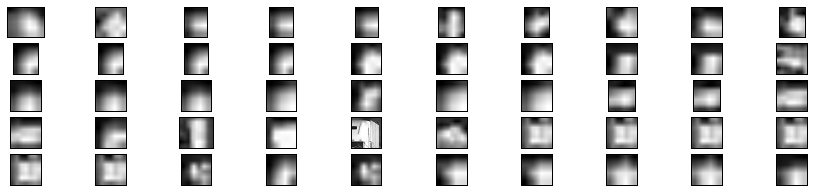

Visual word 35


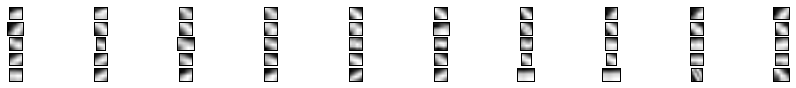

Visual word 41


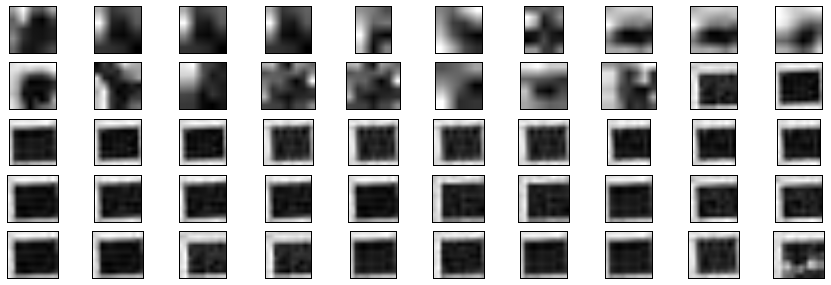

Visual word 64


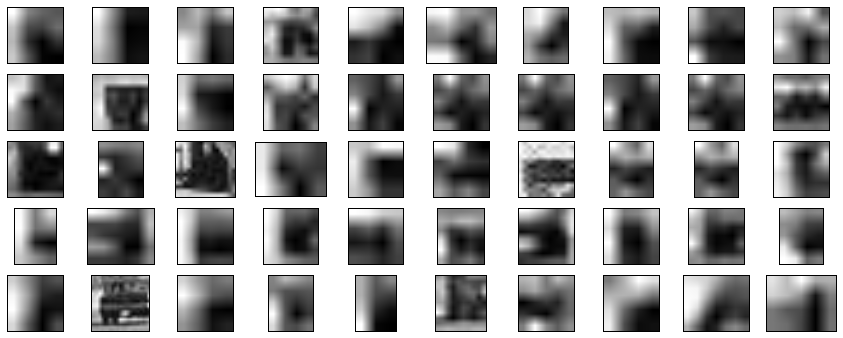

Visual word 65


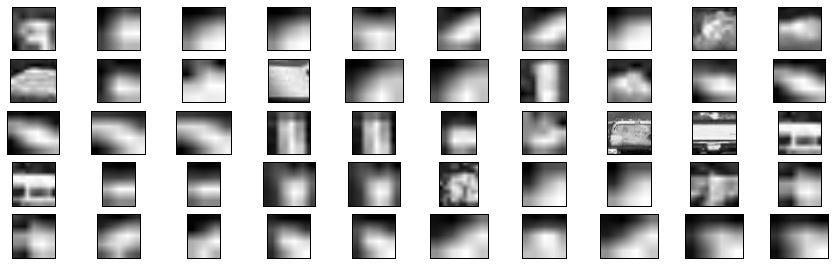

Visual word 70


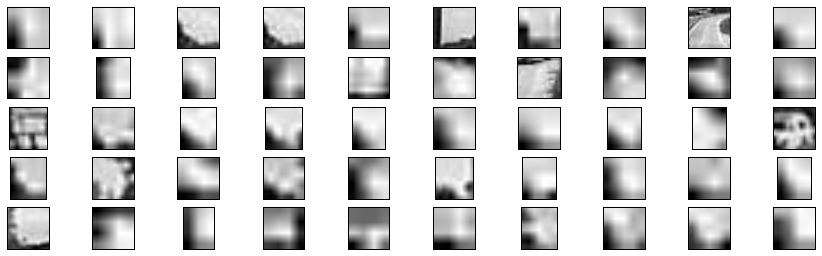

Visual word 78


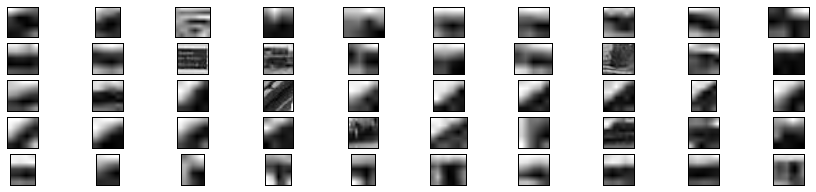

Visual word 101


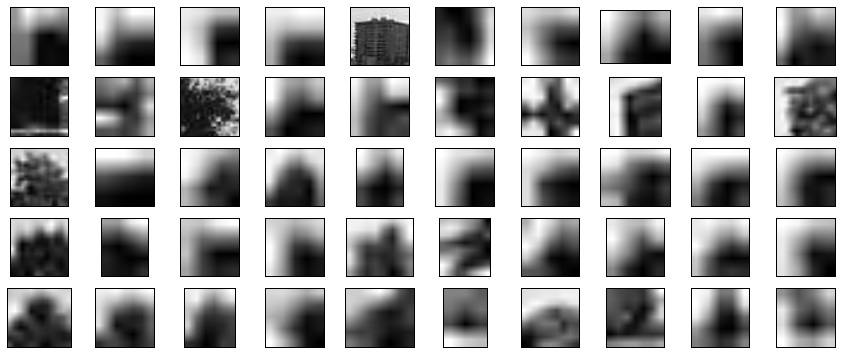

Visual word 118


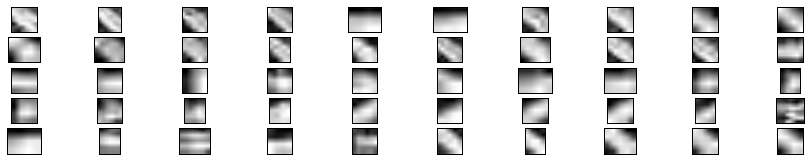

Visual word 127


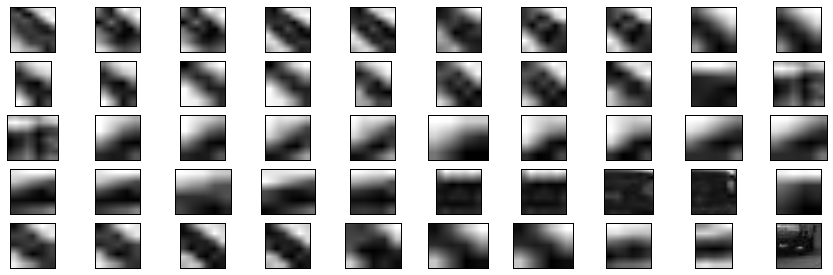

In [47]:
for word in [1, 35, 41, 64, 65, 70, 78, 101, 118, 127]:
    print_visual_word(visual_dict, patches, word) 

##Простейшая классификация с использованием гистограмм визуальных слов

In [26]:
#generator of the train images for the second task
def part_2_image_generator():
    train_dir = "D:\\SHAD\\lab6\\lab6\\part2\\train"
    for image_name in os.listdir(train_dir):
        image = cv2.imread(train_dir+"/"+ image_name)
        yield cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#calculate histogram Bag-of-Words
def get_Bag_of_Words(image, visual_dict, features):
    hist_size = visual_dict.get_params()['n_clusters']
    hist = np.zeros(hist_size)
    sift = cv2.SIFT(nfeatures=features)
    keys, desc = sift.detectAndCompute(image, None)
    for d in desc:
        y = visual_dict.predict(d)
        hist[y-1] = hist[y-1] + 1
    max_val = max(hist)
    return [val / max_val for val in hist]

#code the set of input data
def get_set(visual_dict, set_dir, features):    
    train_dir = "D:\SHAD\lab6\lab6\part2/" + set_dir
    X = []
    y = []
    for image_name in os.listdir(train_dir):
        image = cv2.imread(train_dir+"\\"+ image_name)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        y.append(0) if image_name[:3] == 'cat' else y.append(1)
        X.append(get_Bag_of_Words(gray, visual_dict, features))
    return X, y

In [48]:
#solve the second task: train SVM classifier and measure its accuracy
def solve(dictionary_size):
    visual_dict, patches = get_visual_dictionary(dictionary_size, part_2_image_generator, 100) 
    X_train, y_train = get_set(visual_dict, "train", 100)
    X_test, y_test = get_set(visual_dict, "test", 100)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    print "Visual dictionary size: {0}, Accuracy: {1}".format(dictionary_size, accuracy)

for size in [5, 10, 25, 50, 100]:
    solve(size)

Visual dictionary size: 5, Accuracy: 0.6225
Visual dictionary size: 10, Accuracy: 0.645
Visual dictionary size: 25, Accuracy: 0.67
Visual dictionary size: 50, Accuracy: 0.6425
Visual dictionary size: 100, Accuracy: 0.6875


Как и предполагалось, реализованный алгорим не дал высокого качества. По полученным оценкам качества алгорима можно сделать вывод, что при увеличении размера визуального словаря качество классификации на тествой выборке в целом повышается.